# CDC Model Fits

## Multi-Class Logistic Regression models

Our target class has 3 values: ordinals that have been mapped to the following values  'Likely Decreasing', 'Likely Increasing', 'Uncertain'.

This uses the combined dataset from CDC, Johns Hopkins and Social Mobility/Regulation data

In [1]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor

from sklearn.metrics import accuracy_score,\
 plot_roc_curve, roc_auc_score, f1_score,\
 mean_squared_error, balanced_accuracy_score, r2_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


Here we're using the combined dataset from Johns Hopkins, CDC County data and Social Mobility/Regulations data.

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [3]:
df = pd.read_csv('../data/complete_df.csv')

In [4]:
df.head()

,date,County,County only,FIPS code,State,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,stringency_index,government_response_index,containment_health_index,economic_support_index,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,c3_cancel_public_events,c3_flag,c4_restrictions_on_gatherings,c4_flag,c5_close_public_transport,c5_flag,c6_stay_at_home_requirements,c6_flag,c7_movementrestrictions,c7_flag,c8_internationaltravel,e1_income_support,e1_flag,e2_debtrelief,h1_public_information_campaigns,h1_flag,h2_testing_policy,h3_contact_tracing,h6_facial_coverings,h6_flag,h7_vaccination_policy,h7_flag,h8_protection_of_elderly_people,h8_flag,month,labor_force,employed,unemployed,unemploy_rate,County type,CBSA type,State Abbreviation,Population as a percent of state,Population as a percent of national population,IHE with >5000 full-time enrollment,IHE Full-time enrollment as a percent of the population,Cases as a percent of national total - last 7 days,Cases - % change,Deaths - % change,Cases as a percent of national total - previous 7 days,Rapid rise (last 14 days),Number of days of downward case trajectory,Area of Concern Category,Rapid Riser Category,Community Transmission Level - last 7 days,Community Transmission Level - previous 7 days,Viral (RT-PCR) lab test positivity rate - last 7 days (may be an underestimate due to delayed reporting),% tests resulted in 3 or fewer days - last 7 days,Viral (RT-PCR) lab test positivity rate - absolute change (may be an underestimate due to delayed reporting),Total RT-PCR diagnostic tests - % change (may be an underestimate due to delayed reporting),Testing latency - absolute change,% tests resulted in 3 or fewer days - absolute change,Confirmed COVID-19 admissions - last 7 days,Confirmed COVID-19 admissions per 100 inpatient beds - last 7 days,Suspected COVID-19 admissions - last 7 days,Suspected COVID-19 admissions per 100 inpatient beds - last 7 days,% inpatient beds occupied,% inpatient beds occupied by COVID-19 patient,% staffed adult ICU beds occupied,% staffed adult ICU beds occupied by COVID-19 patient,% ventilators in use,% ventilators in use by COVID-19 patient,Confirmed COVID-19 admissions per 100 inpatient beds - percent increase,Suspected COVID-19 admissions per 100 inpatient beds - percent increase,% inpatient beds occupied - absolute change,% inpatient beds occupied by COVID-19 patient - absolute change,% staffed adult ICU beds occupied - absolute change,% staffed adult ICU beds occupied by COVID-19 patient - absolute change,% ventilators in use - absolute change,% ventilators in use by COVID-19 patient - absolute change,% hospital CCNs reporting any utilization data at least once - last 7 days,% hospital CCNs reporting all utilization data at least once - last 7 days,% hospital CCNs ever reporting utilization data,% hospital CCNs reporting COVID-19 admissions at least once - last 7 days,People who are fully vaccinated as % of total population,People who are fully vaccinated as % of population - ages 65+,% Uninsured,% In Poverty,% Over Age 65,Average household size,% Non-Hispanic Black,% Hispanic,% Non-Hispanic Native American / Alaskan Native,% Non-Hispanic Asian,SVI score,CCVI score,Forecasted case trajectory,Viral (RT-PCR) lab test positivity rate - absolute change (may be an underestimate due to delayed reporting).1,Total RT-PCR diagnostic tests - % change (may be an underestimate due to delayed reporting).1,Testing latency - absolute change.1,% tests resulted in 3 or fewer days - absolute change.1,Viral (RT-PCR) lab test positivity rate - 15-21 days ago (may be an underestimate due to delayed reporting),% tests resulted in 3 or fewer days - 15-21 days ago,% Native American / Alaskan Native,% Asian,ihe_plus_5000_fte_cat,rapid_riser_cat,forecast_case_traj_cat,ar

In [5]:
target_name = 'forecast_case_traj_cat'

The following columns were excluded since the data was in literals, were difficult for the model to digest like longitude and lattitude, or similar features were included

In [6]:
drop_columns=['month','date','County','County only','FIPS code','State','Forecasted case trajectory','County type','CBSA type', 'State Abbreviation', 'Area of Concern Category',
              'Community Transmission Level - last 7 days','Community Transmission Level - previous 7 days','Rapid Riser Category','forecast_case_traj_cat', 'Lat', 'Long_']


In [7]:
X = df.drop(columns = drop_columns)
X.head()

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,stringency_index,government_response_index,containment_health_index,economic_support_index,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,c3_cancel_public_events,c3_flag,c4_restrictions_on_gatherings,c4_flag,c5_close_public_transport,c5_flag,c6_stay_at_home_requirements,c6_flag,c7_movementrestrictions,c7_flag,c8_internationaltravel,e1_income_support,e1_flag,e2_debtrelief,h1_public_information_campaigns,h1_flag,h2_testing_policy,h3_contact_tracing,h6_facial_coverings,h6_flag,h7_vaccination_policy,h7_flag,h8_protection_of_elderly_people,h8_flag,labor_force,employed,unemployed,unemploy_rate,Population as a percent of state,Population as a percent of national population,IHE with >5000 full-time enrollment,IHE Full-time enrollment as a percent of the population,Cases as a percent of national total - last 7 days,Cases - % change,Deaths - % change,Cases as a percent of national total - previous 7 days,Rapid rise (last 14 days),Number of days of downward case trajectory,Viral (RT-PCR) lab test positivity rate - last 7 days (may be an underestimate due to delayed reporting),% tests resulted in 3 or fewer days - last 7 days,Viral (RT-PCR) lab test positivity rate - absolute change (may be an underestimate due to delayed reporting),Total RT-PCR diagnostic tests - % change (may be an underestimate due to delayed reporting),Testing latency - absolute change,% tests resulted in 3 or fewer days - absolute change,Confirmed COVID-19 admissions - last 7 days,Confirmed COVID-19 admissions per 100 inpatient beds - last 7 days,Suspected COVID-19 admissions - last 7 days,Suspected COVID-19 admissions per 100 inpatient beds - last 7 days,% inpatient beds occupied,% inpatient beds occupied by COVID-19 patient,% staffed adult ICU beds occupied,% staffed adult ICU beds occupied by COVID-19 patient,% ventilators in use,% ventilators in use by COVID-19 patient,Confirmed COVID-19 admissions per 100 inpatient beds - percent increase,Suspected COVID-19 admissions per 100 inpatient beds - percent increase,% inpatient beds occupied - absolute change,% inpatient beds occupied by COVID-19 patient - absolute change,% staffed adult ICU beds occupied - absolute change,% staffed adult ICU beds occupied by COVID-19 patient - absolute change,% ventilators in use - absolute change,% ventilators in use by COVID-19 patient - absolute change,% hospital CCNs reporting any utilization data at least once - last 7 days,% hospital CCNs reporting all utilization data at least once - last 7 days,% hospital CCNs ever reporting utilization data,% hospital CCNs reporting COVID-19 admissions at least once - last 7 days,People who are fully vaccinated as % of total population,People who are fully vaccinated as % of population - ages 65+,% Uninsured,% In Poverty,% Over Age 65,Average household size,% Non-Hispanic Black,% Hispanic,% Non-Hispanic Native American / Alaskan Native,% Non-Hispanic Asian,SVI score,CCVI score,Viral (RT-PCR) lab test positivity rate - absolute change (may be an underestimate due to delayed reporting).1,Total RT-PCR diagnostic tests - % change (may be an underestimate due to delayed reporting).1,Testing latency - absolute change.1,% tests resulted in 3 or fewer days - absolute change.1,Viral (RT-PCR) lab test positivity rate - 15-21 days ago (may be an underestimate due to delayed reporting),% tests resulted in 3 or fewer days - 15-21 days ago,% Native American / Alaskan Native,% Asian,ihe_plus_5000_fte_cat,rapid_riser_cat,area_of_concern_cat,cases_national_total_change,total_full_vac_%_change,age_65_full_vac_%_change,com_trans_last7_cat,cbsa_type_cat,county_type_cat,daily_deaths,daily_confirmed_cases
0,-17.0,-10.0,-11.0,-1.0,-18.0,8.0,49.07,55.36,57.92,37.5,2.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0

In [8]:

y = df['forecast_case_traj_cat']

y = LabelEncoder().fit_transform(y)  # Didn't really make a difference

Scale data

In [9]:
ss = StandardScaler(with_mean=False)
X_ss = ss.fit_transform(X)

X_ss_train, X_ss_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.1, stratify=y)

pd.DataFrame(y_train).value_counts()

1    274243
0     33720
2       267
dtype: int64

Smote scaled data to balance out classes

In [10]:
#sampling_strategy
smo = SMOTE()
X_ss_smo_train, y_ss_smo_train = smo.fit_resample(X_ss_train, y_train)


In [11]:
pd.DataFrame(y_ss_smo_train).value_counts().to_frame().rename(columns={0:'y_train_counts'})


,y_train_counts
0,
0,274243
1,274243
2,274243


In [12]:
pd.DataFrame(y_test).value_counts().to_frame().rename(columns={0:'y_test_counts'})


,y_test_counts
0,
1,30472
0,3746
2,30


In [13]:
pd.DataFrame(y_test).value_counts(normalize=True).to_frame().rename(columns={0:'y_test_counts'})


,y_test_counts
0,
1,0.889745
0,0.109379
2,0.000876


In [14]:
pd.DataFrame(y_test).value_counts().to_frame().rename(columns={0:'y_test_counts'})


,y_test_counts
0,
1,30472
0,3746
2,30


We ran below a number of times and on some occasions it has converged with the parameters below, on others, the machine needed to completely restart the jupyter notebook server and the browser was relaunched.

In [15]:

lr_smo = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 5000)

lr_smo.fit(X_ss_smo_train, y_ss_smo_train)


LogisticRegression(max_iter=5000, multi_class='multinomial')

In [16]:
preds_smo = lr_smo.predict(X_ss_test)
pd.DataFrame([{'train':accuracy_score(y_ss_smo_train, lr_smo.predict(X_ss_smo_train)),
              'test':accuracy_score( y_test,preds_smo), 'model': 'logreg_smo'}]).set_index('model')

,train,test
model,,
logreg_smo,0.511648,0.33672


In [17]:
pd.DataFrame(preds_smo).value_counts().to_frame().rename(columns={0:'y_preds_counts'})

,y_preds_counts
0,
0,14481
1,10078
2,9689


In [18]:
pd.DataFrame([{'train':accuracy_score(y_ss_smo_train, lr_smo.predict(X_ss_smo_train)),
              'test':accuracy_score( y_test,preds_smo), 'model': 'logreg_smo'}]).set_index('model')

,train,test
model,,
logreg_smo,0.511648,0.33672


## Correlations

To check out the most significant correlations with the generated predictions and the true values, we do the following:
* Concatenate the scaled X test data with the target true and predicted values
* Create a dataframe out of the correlated predictions
* Look at the correlations for y_pred (predictions) and y_test (true)
* Sort those correlations by the **absolute** values for **true** values
* Identify those stronger correlations that are from CDC data

In [19]:
pred_df = pd.concat([X_ss_test.reset_index(), 
                     pd.DataFrame(y_test, columns=['y_test']),
                     pd.DataFrame(preds_smo, columns=['y_pred'])], axis=1)

In [20]:
full_y_test_corr_df = pred_df.corr()[['y_test', 'y_pred']]
full_y_test_corr_df[((abs(full_y_test_corr_df['y_test']) > .10))].sort_values('y_test',key=abs, ascending=False)

,y_test,y_pred
y_test,1.000000,0.146702
area_of_concern_cat,0.229620,0.264845
% ventilators in use,-0.150022,-0.150865
y_pred,0.146702,1.000000
% staffed adult ICU beds occupied,-0.144776,-0.121899
county_type_cat,-0.142444,-0.094312
cbsa_type_cat,0.141185,0.084885
% staffed adult ICU beds occupied by COVID-19 patient,-0.138463,-0.174650
% inpatient beds occupied by COVID-19 patient,-0.128176,-0.221792
% ventilators in use by COVID-19 patient,-0.117548,-0.157442


In [21]:
corr_cols = ['cbsa_type_cat', 'area_of_concern_cat', 'Cases as a percent of national total - last 7 days',
             'People who are fully vaccinated as % of total population',
             'com_trans_last7_cat', 
                  'People who are fully vaccinated as % of population - ages 65+',
                  '% ventilators in use by COVID-19 patient',
                  'stringency_index',
                  '% staffed adult ICU beds occupied','y_pred','y_test']

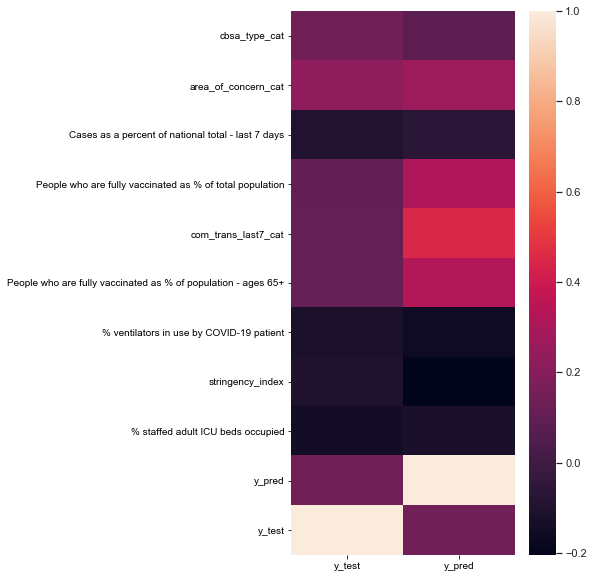

In [22]:
fig, ax = plt.subplots(figsize=(5, 10))  

corr_df = pred_df[corr_cols].corr()[['y_test', 'y_pred']]
corr_df

ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='black')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='black')
sns.set(font_scale=1.0)
sns.heatmap(corr_df, ax=ax, )
plt.savefig('./pred-heatmap.png')


In [23]:
corr_col_names = ['com_trans_last7_cat', 
                  'People who are fully vaccinated as % of population - ages 65+',
                  '% ventilators in use by COVID-19 patient',
                  'stringency_index',
                  '% staffed adult ICU beds occupied'
                  'forecast_case_traj_cat']

In [24]:
df[['com_trans_last7_cat', 'People who are fully vaccinated as % of population - ages 65+', 'forecast_case_traj_cat']].corr()

,com_trans_last7_cat,People who are fully vaccinated as % of population - ages 65+,forecast_case_traj_cat
com_trans_last7_cat,1.000000,0.411822,0.113258
People who are fully vaccinated as % of population - ages 65+,0.411822,1.000000,0.112133
forecast_case_traj_cat,0.113258,0.112133,1.000000


In [25]:
lr_bal = LogisticRegression(class_weight = 'balanced', multi_class='multinomial', solver='lbfgs', max_iter = 5000)

lr_bal.fit(X_ss_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000,
                   multi_class='multinomial')

In [26]:
lr_bal.score(X_ss_train, y_train), lr_bal.score(X_ss_test, y_test)

(0.30022385880673524, 0.30287900023359027)

### Simple LogisticRegression without balancing or smoting

In [27]:

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 4000)

lr.fit(X_ss_train, y_train)
lr.score(X_ss_train, y_train), lr.score(X_ss_test, y_test)

(0.8882393018200694, 0.8881686521840692)

In [28]:
lr_preds=lr.predict(X_ss_test).round(0)

#### Plain Logistic Regression Preds

We see that the model doesn't predict the least represented class, even though the score is higher and closer to the baseline

In [29]:
pd.DataFrame(lr_preds).value_counts(normalize=True), pd.DataFrame(y_test).value_counts(normalize=True)

(1    0.996409
 0    0.003591
 dtype: float64,
 1    0.889745
 0    0.109379
 2    0.000876
 dtype: float64)

### From earlier EDA efforts

As part of an early assessment, a random forest was run against the CDC data alone.  This was recreated here.  Note that we were unable to run cross validation or to do much tuning with the random forest since **it would run for hours and often err out after more than 8 hours.**  Since we were unable to further tune it, we did not pursue this model.

The example below is only to show that it was run as part of EDA.

The most early assessment was run with quick and dirty one-hot-encoding of the literal categories; however in checking feature importance, this made it hard to truly understand what was going on.  The data had over 3000 counties and each one would get a very small feature importance for each county.

In [30]:
rfc = RandomForestClassifier(n_estimators = 200)
rfc.fit(X_ss_train, y_train)


RandomForestClassifier(n_estimators=200)

In [31]:
rfc.score(X_ss_train, y_train), rfc.score(X_ss_test,y_test)

(1.0, 0.956055828077552)

In [32]:
# code below is taken from lecture example
d = {'Column Name':X_ss_train.columns.values,'Feature Importance':rfc.feature_importances_}
fi = pd.DataFrame(d)

rfc_fi = fi.sort_values(by=['Feature Importance'], ascending = False).head(500)

rfc_fi.head(200)


,Column Name,Feature Importance
51,Number of days of downward case trajectory,0.043644
49,Cases as a percent of national total - previou...,0.036550
110,daily_confirmed_cases,0.030179
96,Viral (RT-PCR) lab test positivity rate - 15-2...,0.022894
109,daily_deaths,0.022422
93,Total RT-PCR diagnostic tests - % change (may ...,0.021133
52,Viral (RT-PCR) lab test positivity rate - last...,0.020761
47,Cases - % change,0.020069
92,Viral (RT-PCR) lab test positivity rate - abso...,0.019767
40,unemployed,0.019032
